## 10. Analyze the peakTree output

This notebook gives an example how unsupervised learning meathod might support the analysis

#### Resources
- [pyLARDA](https://github.com/lacros-tropos/larda)
- [pyLARDA documentation](https://lacros-tropos.github.io/larda-doc/html/index.html)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
import os
import numpy as np

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt

# pyLARDA provides functions for data loading, file joining, analysis and plotting
# https://github.com/lacros-tropos/larda
import pyLARDA
import pyLARDA.peakTree as pLpT
import pyLARDA.helpers as h
import pyLARDA.Transformations as Transf

using peakTree fastbuilder


In [3]:
%matplotlib inline

In [5]:
larda = pyLARDA.LARDA('filepath').connect(c_info={'altitude': 150})

paths = [
    '/home/jupyter-jhcustadmin/peakTree/output/20240114_0800_Hyy_peakTree.nc4',
]

# either specify a time interval 
time_int = [datetime.datetime(2024,1,14,8,47),
            datetime.datetime(2024,1,14,8,54)]
# or if given empty the whole period in the files will be plotted
# time_int = []
# TODO ^ not working at the moment -------------------------------------------------------------------

trees = larda.read("peakTree", "tree", time_int, [1300, 2300],paths=paths)

savepath = 'plots/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

>> LARDA initialized. Documentation available at https://lacros-tropos.github.io/larda-doc/
campaign list: 
/home/jupyter-jhcustadmin/.local/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


[slice(np.int64(876), np.int64(1010), None)]
(134, 46, 15, 11)


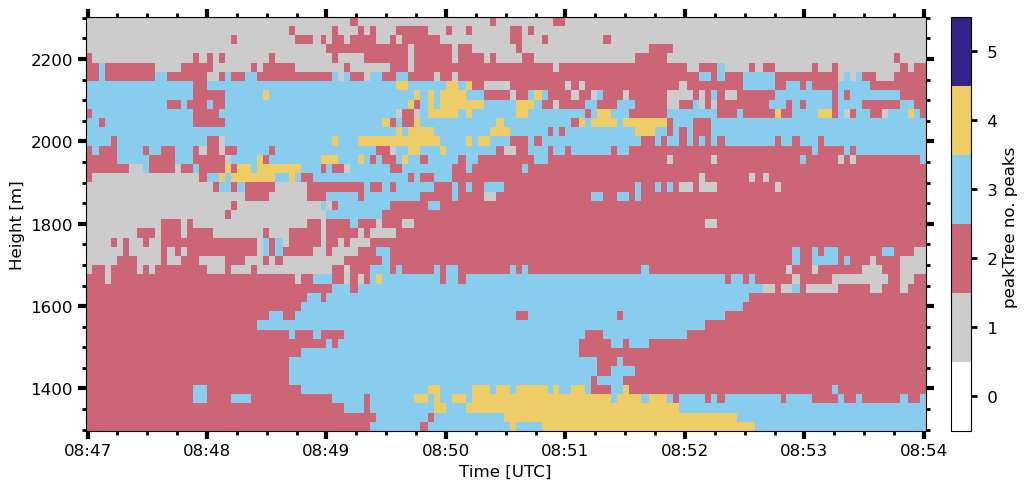

In [6]:
# the tree_to_timeheight selects a 2d array from the ['time', 'range', 'dict'] tree data container
# here just the total number of nodes is returned
# (see https://lacros-tropos.github.io/larda-doc/html/peakTree.html#pyLARDA.peakTree.tree_to_timeheight)
no_nodes = pLpT.tree_to_timeheight(trees, 'no_nodes')
no_nodes['name'] = 'no. nodes'
no_nodes['var_unit'] = ''
fig, ax = pLpT.plot_no_nodes(no_nodes, figsize=[11, 5], no_peaks=True)
ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
ax.xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=1))
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
# fig.savefig(savepath + "{}_no_nodes.png".format(time_int[0].strftime("%Y%m%d-%H%M")), dpi=250)

<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_22649/432241987.py:17: SyntaxWarning: invalid escape sequence '\m'
  v['var_unit'] = 'm s$^\mathrm{-1}$'


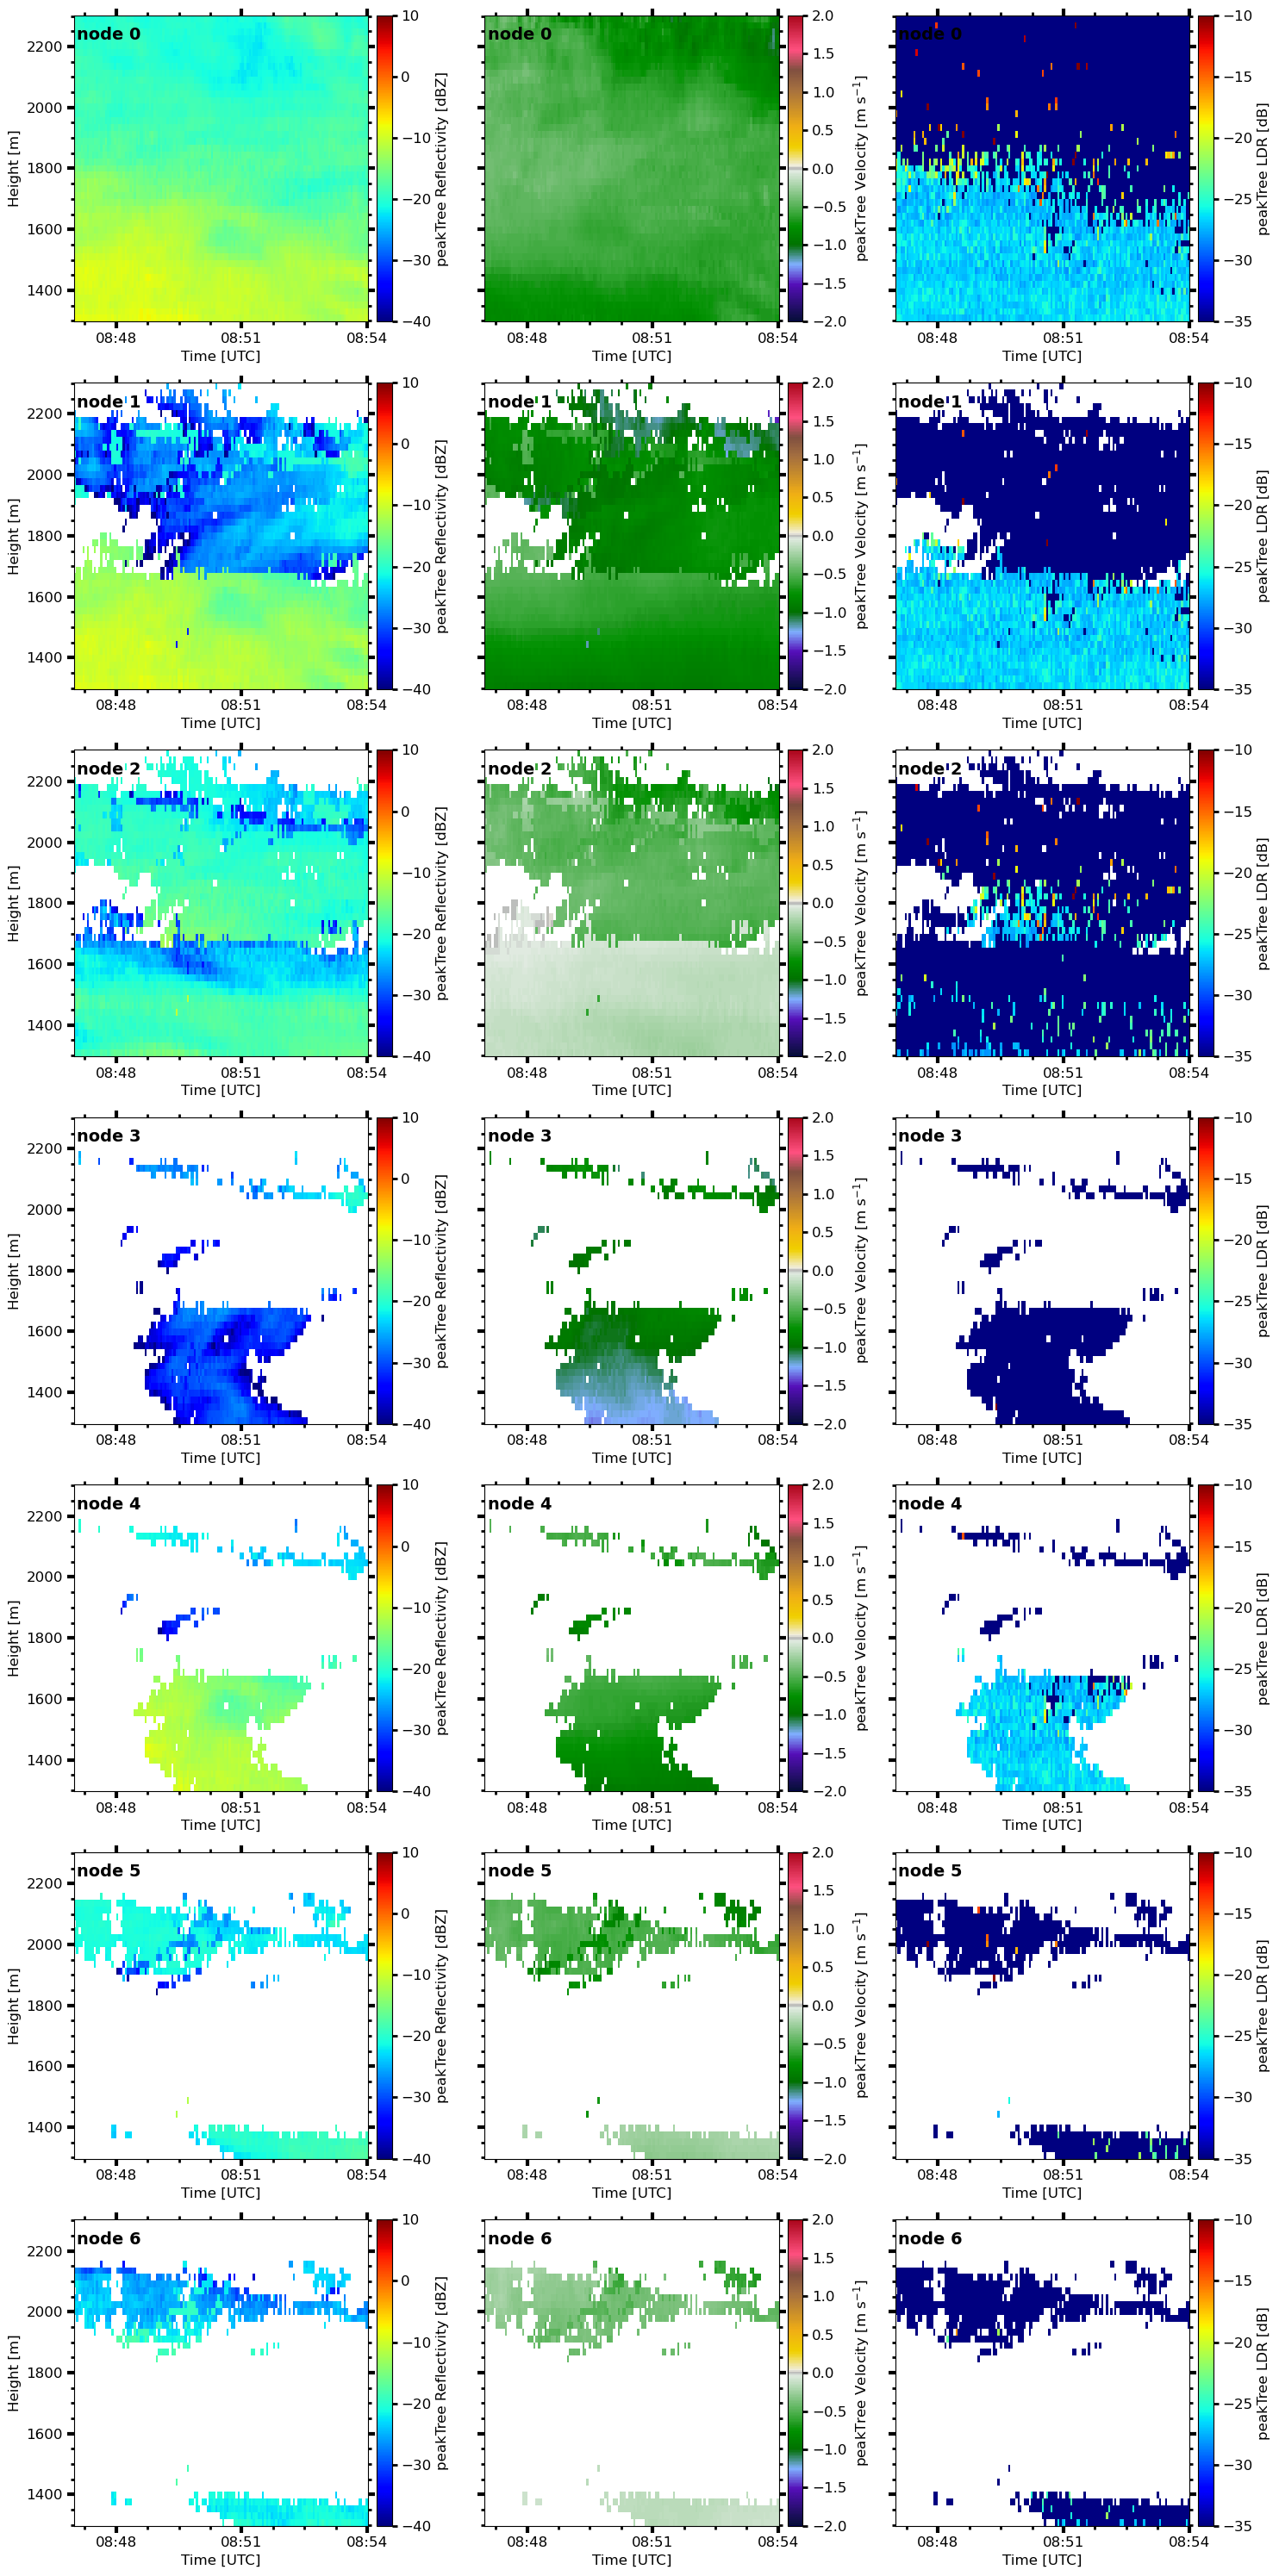

In [7]:
no_nodes_to_plot = 6
fig, ax = plt.subplots(no_nodes_to_plot+1,3, figsize=(15,5*no_nodes_to_plot))
for i in range(0,no_nodes_to_plot+1):
    # do the same selection as above, but for the reflectivity of node i
    z = pLpT.tree_to_timeheight(trees, 'z', sel_node=i)
    z['name'] = 'Reflectivity'
    z['var_unit'] = 'dBZ'
    z['var_lims'] = [-40, 10]
    fig, ax[i,0] = Transf.plot_timeheight2(z, figure=fig, axis=ax[i,0])
    ax[i,0].text(0.01,0.92, f"node {i}", transform=ax[i,0].transAxes, fontweight='semibold', fontsize=14)
    ax[i,0].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax[i,0].xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=3))
    ax[i,0].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

    v = pLpT.tree_to_timeheight(trees, 'v', sel_node=i)
    v['name'] = 'Velocity'
    v['var_unit'] = 'm s$^\mathrm{-1}$'
    v['var_lims'] = [-2, 2]
    v['colormap'] = 'carbonne'
    fig, ax[i,1] = Transf.plot_timeheight2(v, figure=fig, axis=ax[i,1])
    ax[i,1].text(0.01,0.92, f"node {i}", transform=ax[i,1].transAxes, fontweight='semibold', fontsize=14)
    ax[i,1].tick_params(axis='y', labelleft=False)
    ax[i,1].set_ylabel('')
    ax[i,1].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax[i,1].xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=3))
    ax[i,1].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())

    ldr = pLpT.tree_to_timeheight(trees, 'ldr', sel_node=i)
    ldr['name'] = 'LDR'
    ldr['var_unit'] = 'dB'
    ldr['var_lims'] = [-35, -10]
    fig, ax[i,2] = Transf.plot_timeheight2(ldr, figure=fig, axis=ax[i,2])
    ax[i,2].text(0.01,0.92, f"node {i}", transform=ax[i,2].transAxes, fontweight='semibold', fontsize=14)
    ax[i,2].tick_params(axis='y', labelleft=False)
    ax[i,2].set_ylabel('')
    ax[i,2].yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    ax[i,2].xaxis.set_major_locator(matplotlib.dates.MinuteLocator(interval=3))
    ax[i,2].xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator())
    
fig.tight_layout()

In [8]:
# first step extract leaves into the plain data format

def picking_leaves(data_cont):
    """get all the leaves and put them into a ml friendly structure

    Args:
        data_cont: peakTree data container       
    """
    hv, tv = np.meshgrid(data_cont['rg'], data_cont['ts'])
    # print("time resolution", np.diff(data_cont['ts']))
    # print("range resolution", np.diff(data_cont['rg'])[:10])
    
    data = []
    for index, tree in np.ndenumerate(data_cont['var']):
        if tree:
            node_ids = tree.keys()
            parent_ids = [n['parent_id'] if 'parent_id' in n else -1 for n in tree.values()]
            for i in set(node_ids)-set(parent_ids):
                raveled_index = np.ravel_multi_index(index, data_cont['var'].shape)
                d = [tv[index], hv[index], i, tree[i]['z'], tree[i]['v'], tree[i]['ldr'], tree[i]['width'], raveled_index]
                data.append(d)
    return np.array(data)

plain_dat = picking_leaves(trees)
print(plain_dat.shape)

plain_dat[:5,:]

(13532, 8)


array([[ 1.70522202e+09,  1.29682666e+03,  1.00000000e+00,
        -8.49427795e+00, -8.77442479e-01, -2.51828461e+01,
         5.19485101e-02,  0.00000000e+00],
       [ 1.70522202e+09,  1.29682666e+03,  2.00000000e+00,
        -1.89071484e+01, -1.25719577e-01, -6.00000000e+01,
         4.28069159e-02,  0.00000000e+00],
       [ 1.70522202e+09,  1.31918567e+03,  1.00000000e+00,
        -9.40915203e+00, -8.62904429e-01, -2.57214870e+01,
         5.11589386e-02,  1.00000000e+00],
       [ 1.70522202e+09,  1.31918567e+03,  2.00000000e+00,
        -2.04150658e+01, -1.16924666e-01, -6.00000000e+01,
         4.44255732e-02,  1.00000000e+00],
       [ 1.70522202e+09,  1.34154480e+03,  1.00000000e+00,
        -1.03748951e+01, -8.47115219e-01, -2.64832363e+01,
         5.14478721e-02,  2.00000000e+00]])

In [9]:
# use a smaller height slice (for performance and also to keep clustering local)

plain_dat = plain_dat[(plain_dat[:,1] > 1600) & (plain_dat[:,1] < 1800)]
print(plain_dat.shape)

(2441, 8)


In [10]:
print( np.min(plain_dat[:,3]),np.max(plain_dat[:,3]))
zmin, zmax = -50, 10
plain_dat[:,3] = (plain_dat[:,3]-zmin)/(zmax - zmin)

print( np.min(plain_dat[:,4]), np.max(plain_dat[:,4]))
vmin, vmax = -4, 3
plain_dat[:,4] = (plain_dat[:,4]- vmin)/(vmax - vmin)

print(np.min(plain_dat[:,6]), np.max(plain_dat[:,6]))
wmin, wmax = 0.01, 1
plain_dat[:,6] = (plain_dat[:,6]- wmin)/(wmax - wmin)

-48.57957458496094 -11.24120807647705
-1.063286304473877 0.02936830371618271
9.999999747378752e-05 0.12842467427253723


In [11]:
import numba
@numba.njit()
def cust_metric(x, y):
    if x[-1] != 0 and x[-1] == y[-1]:
        # print('double found')
        return 10
    else:
        return np.linalg.norm(x[:-1]-y[:-1])


In [12]:
weights_cluster = np.array([0,0,0,1,0.6,0,0.5,1])

# scikit-learn-contrib / hdbscan produces more robust clusters in that case
import hdbscan
clustering = hdbscan.HDBSCAN(
    metric=cust_metric
    ).fit(plain_dat*weights_cluster)

/opt/tljh/user/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/tljh/user/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [13]:
print(clustering.labels_)
print(np.max(clustering.labels_))

[1 0 1 ... 1 2 1]
3


0 (465, 8)
1 (1204, 8)
2 (743, 8)


/tmp/ipykernel_22649/296514387.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('jet', 6+1)


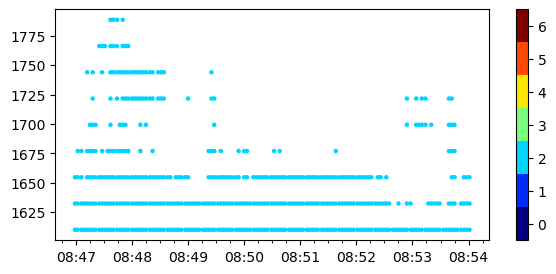

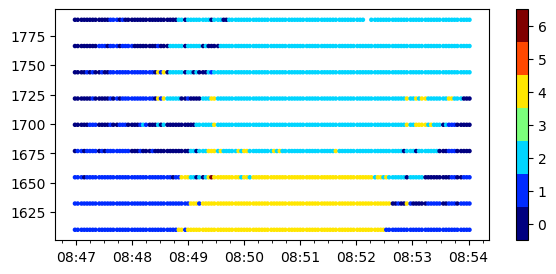

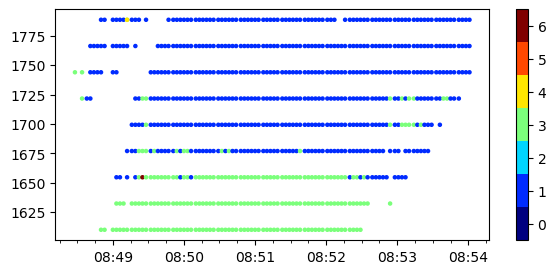

In [14]:
# for ic in range(clustering.n_clusters_):
for ic in range(max(clustering.labels_)):
    d = plain_dat[clustering.labels_==ic,:]
    print(ic, d.shape)

    fig, ax = plt.subplots(figsize=(7,3))
    
    # ts = data[:,-2]*(tv.max() - tv.min()) + tv.min()
    ts =  d[:,0]
    dt_list = [h.ts_to_dt(t) for t in ts]
    # rg = data[:,-1]*(hv.max() - hv.min()) + hv.min()
    rg = d[:,1]
    cmap = plt.cm.get_cmap('jet', 6+1)
    sc = ax.scatter(dt_list, rg, c=d[:,2], cmap=cmap, s=5, vmin=-0.5, vmax=6.5)
    # ax.set_xlim(datetime.datetime(2023,1,1),datetime.datetime(2023,1,11))
    fig.colorbar(sc)
    
    ax.xaxis.set_minor_locator(matplotlib.dates.HourLocator(interval=3))
    ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(n=4))
    #ax[0].yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(1000))
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))

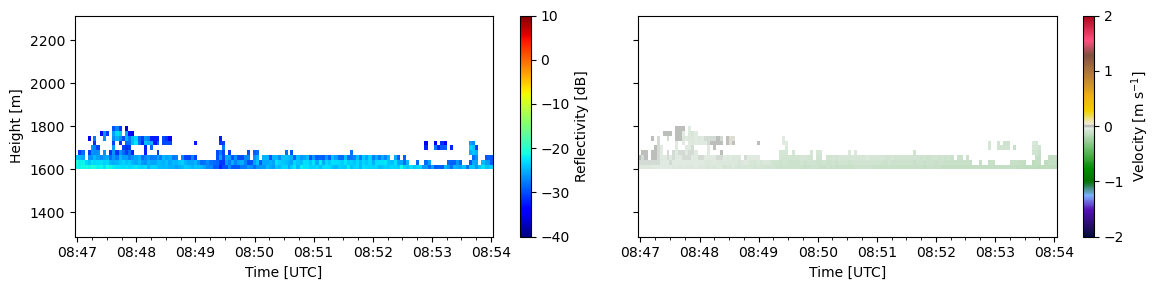

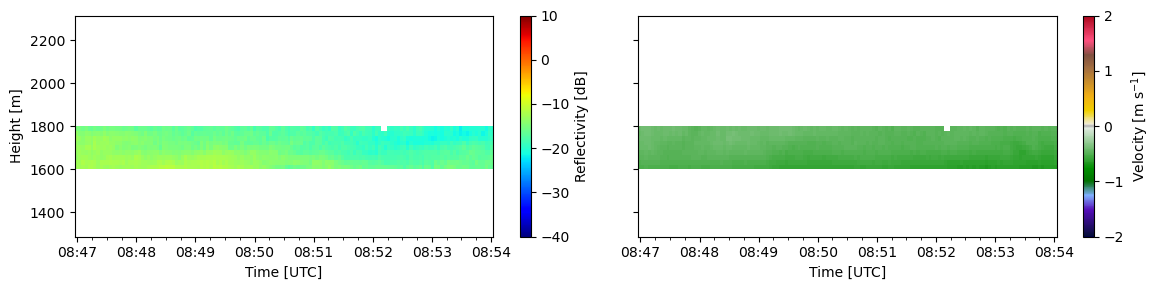

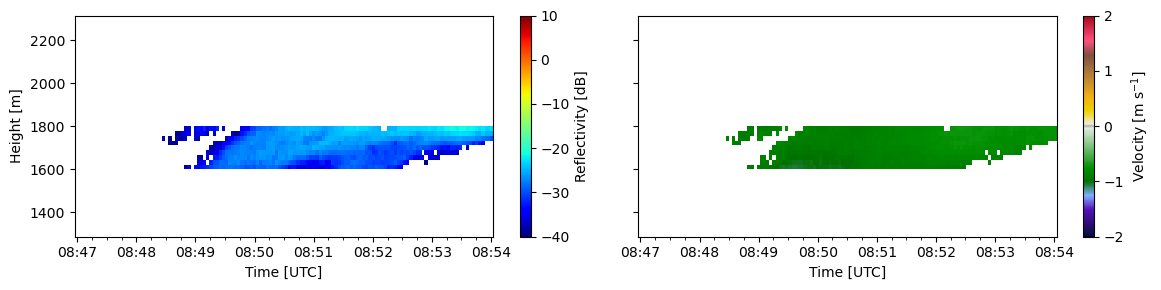

In [15]:
dt_list = [h.ts_to_dt(t) for t in trees['ts']]

def resample_original_grid(d, ts, rg, col):
    var = np.empty((ts.shape[0], rg.shape[0]))
    var[:] = np.nan
    for i in range(d.shape[0]):
        idx = np.unravel_index(int(d[i,-1]), (ts.shape[0], rg.shape[0]))
        var[idx] = d[i,col]
    return var

for ic in range(max(clustering.labels_)):

    fig, ax = plt.subplots(1,2, figsize=(12,3))
    d = plain_dat[clustering.labels_==ic,:]

    Z = resample_original_grid(d, trees['ts'], trees['rg'],3)
    Z = Z*(zmax - zmin) + zmin
    pcmesh = ax[0].pcolormesh(dt_list, trees['rg'], Z.T, cmap='jet', vmin=-40, vmax=10)
    cb = fig.colorbar(pcmesh, pad=0.05)
    cb.set_label('Reflectivity [dB]')
    ax[0].set_ylabel('Height [m]')
    ax[0].set_xlabel('Time [UTC]')

    #fig, ax = plt.subplots(figsize=(5,3))
    v = resample_original_grid(d, trees['ts'], trees['rg'],4)
    v = v*(vmax - vmin) + vmin
    pcmesh = ax[1].pcolormesh(dt_list, trees['rg'], v.T, cmap=pyLARDA.VIS_Colormaps.carbonne_map, vmin=-2, vmax=2)
    cb = fig.colorbar(pcmesh, pad=0.05)
    cb.set_label('Velocity [m s$^{-1}$]')
    ax[1].tick_params(axis='y', labelleft=False)
    ax[1].set_ylabel('')
    ax[1].set_xlabel('Time [UTC]')
    
    for a in ax:
        a.xaxis.set_minor_locator(matplotlib.dates.HourLocator(interval=3))
        a.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(n=4))
        a.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%H:%M'))
    fig.tight_layout()

In [16]:
# diagnostics
# check if nodes at a single time and height are double assiged

unq, unq_idx, unq_cnt = np.unique(plain_dat[:,7], return_inverse=True, return_counts=True)
print(unq[unq_cnt > 1].shape)
for not_unique in unq[unq_cnt > 1]:
    # print('not unique ', not_unique)
    idx = np.where(not_unique == plain_dat[:,7])[0]
    print('idx', idx)

    print('lbl: ', clustering.labels_[idx])

(1007,)
idx [0 1]
lbl:  [1 0]
idx [2 3]
lbl:  [1 0]
idx [4 5]
lbl:  [1 0]
idx [12 13]
lbl:  [1 0]
idx [14 15]
lbl:  [1 0]
idx [16 17]
lbl:  [1 0]
idx [18 19]
lbl:  [1 0]
idx [25 26]
lbl:  [1 0]
idx [27 28]
lbl:  [1 0]
idx [29 30]
lbl:  [1 0]
idx [31 32]
lbl:  [1 0]
idx [38 39]
lbl:  [1 0]
idx [40 41]
lbl:  [1 0]
idx [49 50]
lbl:  [1 0]
idx [51 52]
lbl:  [1 0]
idx [53 54]
lbl:  [1 0]
idx [55 56]
lbl:  [1 0]
idx [59 60]
lbl:  [1 0]
idx [63 64]
lbl:  [1 0]
idx [65 66]
lbl:  [1 0]
idx [67 68]
lbl:  [1 0]
idx [69 70]
lbl:  [1 0]
idx [71 72]
lbl:  [1 0]
idx [77 78]
lbl:  [1 0]
idx [79 80]
lbl:  [1 0]
idx [81 82]
lbl:  [1 0]
idx [83 84]
lbl:  [1 0]
idx [85 86]
lbl:  [1 0]
idx [87 88]
lbl:  [1 0]
idx [89 90]
lbl:  [1 0]
idx [93 94]
lbl:  [1 0]
idx [95 96]
lbl:  [1 0]
idx [97 98]
lbl:  [1 0]
idx [ 99 100]
lbl:  [1 0]
idx [101 102]
lbl:  [1 0]
idx [107 108]
lbl:  [1 0]
idx [109 110]
lbl:  [1 0]
idx [111 112]
lbl:  [1 0]
idx [117 118]
lbl:  [1 0]
idx [120 121]
lbl:  [1 0]
idx [122 123]
lbl:  [1 0